In [1]:
from moss.mosaic import Mosaic
import nibabel as nib
import multiprocessing
#os and i/o
import os
import numpy as np
import os.path as op
import seaborn as sns
import matplotlib
import scipy
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [38]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
subs = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)

In [56]:
exp = 'sim_4mm-onebeta'
overlap_masks = ['peri_sim','para_sim','hipp']
masks = overlap_masks[:]
smooth = 'smoothed'
# masks = ['rh-hippocampus-tail','rh-hippocampus-body','rh-hippocampus-head',
#         'lh-hippocampus-tail','lh-hippocampus-body','lh-hippocampus-head']
# masks = ['peri_sim','para_sim','hipp',
#          'VTC_sim','cortex_fill_sim','accumbens_sim',
#          'entorhinal', 'V1_fill_sim',
#          'lOFC_fill_sim','mOFC_fill_sim']
# masks = ['yeo17_ifs','yeo17_fpc',
#          'lOFC_fill_sim','mOFC_fill_sim']
masks = ['entorhinal','peri_sim','para_sim','hipp','hipp_right','hipp_left',
         'VTC_sim']

In [57]:
def trim_mask(mask,m):
    exclusions = overlap_masks[:]
    exclusions.remove(m)

    m1 = op.abspath('./data/' + sub + '/masks/' + exclusions[0] +'.nii.gz')
    m1 = nib.load(m1).get_data().astype(bool)

    m2 = op.abspath('./data/' + sub + '/masks/' + exclusions[1] +'.nii.gz')
    m2 = nib.load(m2).get_data().astype(bool)

    bad = np.logical_or(m1,m1)
    good = np.invert(bad)

    mask = np.logical_and(mask,good)
    return mask

In [58]:
roi_rsa = {}
for m in masks:
    all_rsas = []
    all_means = []
    for sub in subs:
        sub_path = op.abspath('./analysis/' + exp + '/' + sub + '/reg/epi/' + smooth + '/')

        mask = op.abspath('./data/' + sub + '/masks/' + m +'.nii.gz')
        mask = nib.load(mask).get_data().astype(bool)
        if m in overlap_masks:
            mask = trim_mask(mask,m)

        runs = []
        rsa = []
        run_means = []
        for run in map(str,range(1,4)):
            run_dir = sub_path + '/run_'  + run
            if os.path.exists(run_dir):
                stats = []
                mean_signal = []
                
                for i in [1,2,3,4]:
                    f = run_dir + '/cope' + str(i) + '_xfm.nii.gz'
                    var = run_dir + '/varcope' + str(i) + '_xfm.nii.gz'

                    var = nib.load(var).get_data().astype(float)

                    var = var[mask]
                    std = np.sqrt(var)

                    stat = nib.load(f).get_data().astype(float)
                    stat = stat[mask]

                    weighted = stat #/ std
                    mean_signal.append(np.mean(weighted))
                    
                    stats.append(weighted)

                stats = np.array(stats)
                runs.append(stats)
                run_means.append(mean_signal)
        
        all_means.append(np.mean(run_means,axis=0))
        runs = np.array(runs)
        rsa = between_run_correlation(runs)
        all_rsas.append(rsa)
    
    #make figures
    rsa_norm, fig_mask = get_mean_rsa(all_rsas)
    make_fig(rsa_norm, fig_mask, m, smooth)
    plt.clf()
    make_sig_fig(all_rsas,fig_mask, m, smooth)
    plt.clf()
    roi_rsa[m] = all_rsas
    print 'done',m

done entorhinal
done peri_sim
done para_sim
done hipp
done hipp_right
done hipp_left
done VTC_sim


In [6]:
def mask_corr(runs,x,y,i,j):
    a = runs[x,i,:]
    b = runs[y,j,:]

    good = np.logical_and(np.isfinite(a),np.isfinite(b))

    a = a[good]
    b = b[good]

    r,p = scipy.stats.pearsonr(a,b)
#     r,p = scipy.spatial.distance.mahalanobis(a,b)
    return r

In [7]:
def between_run_correlation(runs):
    nconds = 4
    nruns = runs.shape[0]
    rsa = np.zeros((nconds,nconds))

    for i in range(0,nconds):
        for j in range(0,nconds):
            corr = []

            corr.append(mask_corr(runs,0,1,i,j))
            corr.append(mask_corr(runs,1,0,i,j))
            
            if nruns == 3:
                
                corr.append(mask_corr(runs,0,2,i,j))
                corr.append(mask_corr(runs,1,2,i,j))
                corr.append(mask_corr(runs,2,0,i,j))
                corr.append(mask_corr(runs,2,1,i,j))
            
            rsa[i,j]  = np.nanmean(corr)
    return rsa

In [8]:
def get_mean_rsa(all_rsas):
    all_rsas = np.array(all_rsas)
    mean_rsa = np.nanmean(all_rsas,axis=0)
    
    mask = np.zeros_like(mean_rsa) + 1
    mask = np.triu(mask,k=1).astype(int)

    lower = np.tril(mean_rsa)
    lower[lower == 0] = np.nan
    rsa_norm = (mean_rsa - np.nanmean(lower)) / np.nanstd(lower)
    
    return rsa_norm, mask
# print rsa_norm
# conds = ['AB+','AC-','B-','C+']
# df = {'AB+': rsa_norm[:,0],
#      'AC-': rsa_norm[:,1],
#      'B-': rsa_norm[:,2],
#      'C+': rsa_norm[:,3]}

# df = pd.DataFrame(df,index = conds)
# df.sort(columns = ['AB+','AC-','B-','C+'])
# df = df[conds]
# print df

In [11]:
def make_fig(rsa_norm, mask,m, smooth):
    conds = ['AB+','AC-','B-','C+']
    df = {'AB+': rsa_norm[:,0],
         'AC-': rsa_norm[:,1],
         'B-': rsa_norm[:,2],
         'C+': rsa_norm[:,3]}

    df = pd.DataFrame(df,index = conds)
    df.sort(columns = ['AB+','AC-','B-','C+'])
    df = df[conds]

    with sns.axes_style("white"):
        ax = sns.heatmap(df, mask= mask, vmax = np.max(rsa_norm), square = True, cmap = 'Blues')
    plt.savefig('/home/iballard/Dropbox/fd/figs/' + m + '_' + smooth + '_unweighted',dpi=200)


In [12]:
def make_sig_fig(all_rsas,mask,m,smooth):
    t,p = scipy.stats.ttest_1samp(np.arctanh(all_rsas),0)
    
    thresh = .05
    pmax = min(np.max(p),.05)
    p[p>thresh] = thresh - .001
    
    with sns.axes_style("white"):
        ax = sns.heatmap(p, mask = mask, vmax = pmax, square = True, cmap = 'Blues_r')
    plt.savefig('/home/iballard/Dropbox/fd/figs/' + m + '_' + smooth + '_pvalues_unweighted.png',dpi=200)

In [235]:
within = []
across = []
for mat in roi_rsa['hipp']:
    
    lower = np.tril(mat)
    lower[lower == 0] = np.nan
    
    mat = (mat - np.nanmean(lower)) / np.nanstd(lower)
    
#     mat = np.arctanh(mat)
    within.append(np.mean([mat[1,0], mat[2,0], mat[3,1]]))
    across.append(np.mean([mat[3,0], mat[2,1], mat[3,2]]))
    
print scipy.stats.ttest_rel(within,across)

Ttest_relResult(statistic=0.76510728036778386, pvalue=0.44999353973481937)


In [59]:
from statsmodels.formula.api import ols
rois= ['VTC_sim','hipp_right','peri_sim','para_sim','entorhinal']
# rois= ['hipp_left','hipp_right','hipp']

# rois= ['mOFC_fill_sim','lOFC_fill_sim','yeo17_fpc','yeo17_ifs']
# rois = ['rh-hippocampus-tail','rh-hippocampus-body','rh-hippocampus-head',
#         'lh-hippocampus-tail','lh-hippocampus-body','lh-hippocampus-head']

res = {'intercept':[],'response':[],'valence':[],'overlap':[],'identity':[],'region':[],'sub':[]}
res_stacked = {'beta':[],'regressor':[],'region':[]}
for roi in rois:
    for sub,rsa in enumerate(roi_rsa[roi]):
        data = pd.DataFrame()
        data['y'] = rsa[np.tril_indices_from(rsa)]
        data['y'] = 1-rsa[np.tril_indices_from(rsa)]
#         data['y'] = np.arctanh(data['y'])

        data['response'] = [1,0,1,0,1,1,1,0,0,1]
        data['valence'] = [1,0,-1,0,-1,-1,1,0,0,1]
        data['overlap'] = [0,1,0,1,0,0,0,1,0,0]
        data['identity'] = [1,0,1,0,0,1,0,0,0,1]
        data['double'] = [1,1,1,0,0,0,0,0,0,0]

        data['response'] = data['response'] - np.mean(data['response'])
        data['valence'] = data['valence'] - np.mean(data['valence'])
        data['overlap'] = data['overlap'] - np.mean(data['overlap'])
        data['identity'] = data['identity'] - np.mean(data['identity'])

        model = ols("y ~ identity + response + valence + overlap", data)    
        fit = model.fit()
        
        res['intercept'].append(fit.params['Intercept'])
        res['response'].append(fit.params['response'])
        res['valence'].append(fit.params['valence'])
        res['overlap'].append(fit.params['overlap'])
        res['identity'].append(fit.params['identity'])
        res['sub'].append(sub)
        res['region'].append(roi)
    
res = pd.DataFrame(res)

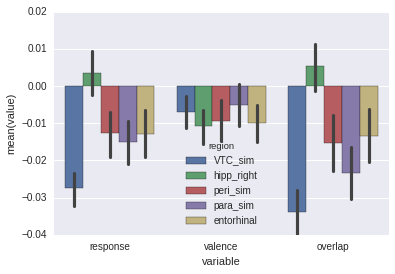

In [62]:
## res_melt = pd.melt(res, id_vars=['region'], value_vars=['response','valence','resp:val','overlap'])
res_melt = pd.melt(res, id_vars=['region'], value_vars=['response','valence','overlap'])

sns.barplot(x='variable',y='value',hue = 'region',data = res_melt, ci = 68)
plt.savefig('/home/iballard/Dropbox/fd/RSA.png')

In [53]:
import statsmodels.api as sm
model = ols("overlap ~ region", res).fit() 
table = sm.stats.anova_lm(model, typ=2)
print table
res.to_csv('/home/iballard/Dropbox/fd/sim_similarity.csv')

            sum_sq   df         F    PR(>F)
region    0.026454    3  5.967879  0.000781
Residual  0.183216  124       NaN       NaN


In [55]:
scipy.stats.ttest_rel(res.loc[res['region'] == 'peri_sim','overlap'],
                     res.loc[res['region'] == 'hipp_right','overlap'])

Ttest_relResult(statistic=-2.1571688104753304, pvalue=0.038859122606813158)

In [65]:
roi_rsa['hipp'][0]

array([[ 0.09246038,  0.06809253,  0.0723557 ,  0.07002456],
       [ 0.06809253,  0.04640508,  0.03430666,  0.03148973],
       [ 0.0723557 ,  0.03430666,  0.01455481,  0.02609865],
       [ 0.07002456,  0.03148973,  0.02609865, -0.00682619]])